# LIVNEH Data - Code to analyze Volatility of Daily Max Temperature 

## 1: Import Libraries

In [1]:
import netCDF4 as nc
import numpy as np
import h5py
import os
import glob 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from datetime import datetime
import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
import pymannkendall as mk
import scipy 
import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
from scipy import stats
import datetime as dt
import calendar

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

## 2: Compute volatility and seasonality of volatility

In [2]:
os.chdir('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/LIVNEH')
files = sorted(glob.glob('*.nc'))
years= np.arange(1950, 2012)

volatility_95p = np.empty([444, 922, len(years)])
volatility_95p[:] = np.nan
daily_climatology = np.empty([444, 922, 365])
daily_climatology[:] = np.nan

for i in range(len(files)):
    
    filename = files[i]
    ds = nc.Dataset(filename)
    data = ds['tmax'][:]
    data = np.transpose(data, (1,2,0))
    data[data > 60] = np.nan
    v= data[:,:,1:] - data[:,:,:-1]
    v= abs(v)
    for lat in range(data.shape[0]):
        for lon in range(data.shape[1]):
            volatility_95p[lat,lon,i] = np.nanpercentile(v[lat,lon,:],95)
            if (v.shape[2]== 365):
                daily_climatology[lat,lon,:] = np.nanmean(np.stack((v[lat,lon,:], daily_climatology[lat,lon,:])), axis= 0)
            else:
                daily_climatology[lat,lon,0:58] = np.nanmean(np.stack((v[lat,lon,0:58], daily_climatology[lat,lon,0:58])), axis= 0)
                daily_climatology[lat,lon,59:] = np.nanmean(np.stack((v[lat,lon,58:], daily_climatology[lat,lon,59:])), axis= 0)    
    
    print(i)

/Users/ombadi/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-2-3ef05daacf25>:25: RuntimeWarning: Mean of empty slice
  daily_climatology[lat,lon,0:58] = np.nanmean(np.stack((v[lat,lon,0:58], daily_climatology[lat,lon,0:58])), axis= 0)
<ipython-input-2-3ef05daacf25>:26: RuntimeWarning: Mean of empty slice
  daily_climatology[lat,lon,59:] = np.nanmean(np.stack((v[lat,lon,58:], daily_climatology[lat,lon,59:])), axis= 0)


0
1


<ipython-input-2-3ef05daacf25>:23: RuntimeWarning: Mean of empty slice
  daily_climatology[lat,lon,:] = np.nanmean(np.stack((v[lat,lon,:], daily_climatology[lat,lon,:])), axis= 0)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


## 3: Climatology of Volatility in Daily Max Temperature

/var/folders/7w/nnzrfjfj5gz9zc9frrbd74v00000gp/T/ipykernel_33367/3698410180.py:17: RuntimeWarning: Mean of empty slice
  plot = plt.pcolormesh(gridlons, gridlats, np.nanmean(volatility_95p, axis= 2),


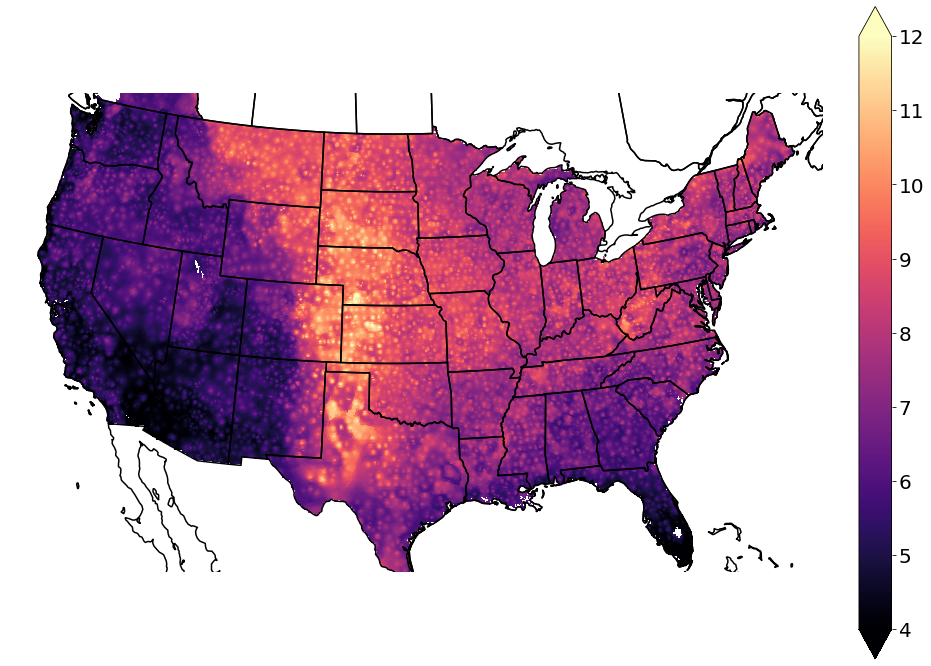

In [3]:
volatility_95p = np.load('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/LIVNEH_volatility95p.csv.npy')

from mpl_toolkits.axes_grid1 import make_axes_locatable

figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))

ax.axis('off')
ax.add_feature(cfeature.COASTLINE, linestyle='-', edgecolor= 'black', linewidth=1.5)
ax.add_feature(cfeature.STATES, linestyle='-', edgecolor= 'black', linewidth=1.5)
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())

gridlons= np.arange(-124.5937,-67.03,0.0625)
gridlats= np.arange(25.1562,52.8438,0.0625)
plot = plt.pcolormesh(gridlons, gridlats, np.nanmean(volatility_95p, axis= 2), 
                      transform=crs.PlateCarree(), cmap= 'magma', vmin= 4, vmax= 12)

font = {'family':'serif','weight':'bold', 'size': 16}

cbar= plt.colorbar(plot,fraction=0.046, pad=0.04, extend= 'both')
cbar.ax.tick_params(labelsize=20) 

plt.savefig('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/Figures/LIVNEH_Climatology_Volatility95p_1950_2011.jpeg',
           dpi=600)

plt.show()

## 4: Seasonality of Volatility

In [4]:
julian_day = np.empty([444, 922])
julian_day[:] = np.nan

julian_day = np.argmax(daily_climatology, axis= 2)
dummy = np.nanmean(volatility_95p, axis= 2)
julian_day = julian_day.astype(float)

for lat in range(dummy.shape[0]):
    for lon in range(dummy.shape[1]):
        if np.isnan(dummy[lat,lon]):
            julian_day[lat,lon] = np.nan

julian_day.shape

<ipython-input-4-a4930fcf2697>:5: RuntimeWarning: Mean of empty slice
  dummy = np.nanmean(volatility_95p, axis= 2)


(444, 922)

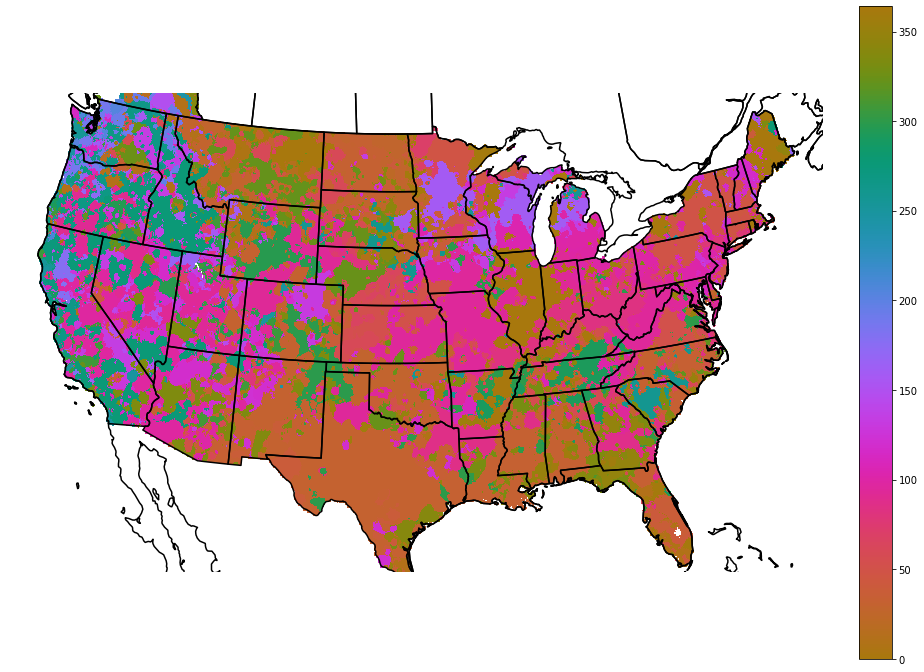

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean

figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))

ax.axis('off')
ax.add_feature(cfeature.COASTLINE, linestyle='-', edgecolor= 'black', linewidth=1.5)
ax.add_feature(cfeature.STATES, linestyle='-', edgecolor= 'black', linewidth=1.5)
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())

gridlons= np.arange(-124.5937,-67.03,0.0625)
gridlats= np.arange(25.1562,52.8438,0.0625)
plot = plt.pcolormesh(gridlons, gridlats, julian_day, transform=crs.PlateCarree(), 
                 cmap= cmocean.cm.phase)

font = {'family':'serif','weight':'bold', 'size': 16}
cbar= plt.colorbar(plot,fraction=0.046, pad=0.04)

plt.savefig('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/Figures/LIVNEH_Seasonality_Volatility.jpeg',
           dpi=600)

plt.show()

## 5: Trends of Volatility

In [9]:
slope = np.empty([444, 922])
slope[:] = np.nan

p_value = np.empty([444, 922])
p_value[:] = np.nan

for lat in range(volatility_95p.shape[0]):
    for lon in range(volatility_95p.shape[1]):
        if ~np.isnan(volatility_95p[lat,lon,0]):
            x = volatility_95p[lat,lon,:]
            result = mk.original_test(x)
            slope[lat,lon] = result.slope
            p_value[lat,lon] = result.p

In [10]:
x = np.sort(p_value.flatten())
y = (np.arange(1, len(x)+1)/len(x))*0.05
alpha_new = max(x[x<y])
alpha_new

0.009836276335396965

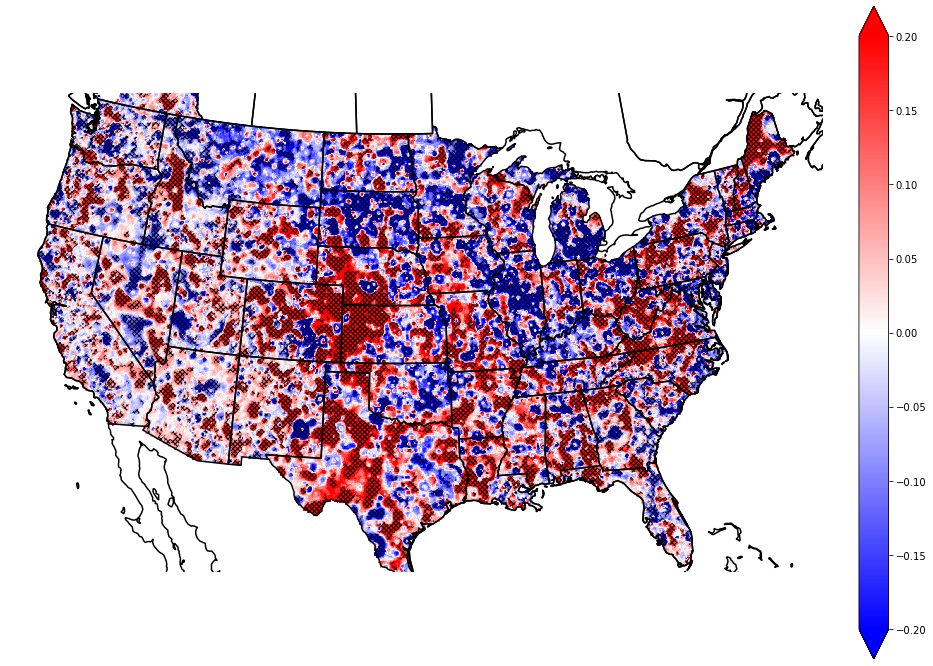

In [23]:
#slope = np.load('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Feb Results/LIVNEH_trend_sen_slope.csv.npy')
figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))

ax.axis('off')
ax.add_feature(cfeature.COASTLINE, linestyle='-', edgecolor= 'black', linewidth=1.5)
ax.add_feature(cfeature.STATES, linestyle='-', edgecolor= 'black', linewidth=1.5)
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())

gridlons= np.arange(-124.5937,-67.03,0.0625)
gridlats= np.arange(25.1562,52.8438,0.0625)

lons = (gridlons[:-1] + gridlons[1:])/2
lats = (gridlats[:-1] + gridlats[1:])/2

plot = plt.pcolormesh(gridlons, gridlats, slope*10, cmap= 'bwr', transform=crs.PlateCarree(), 
                      vmin= -0.2, vmax= 0.2, alpha= 1)

ax.contourf(gridlons, gridlats, (p_value <= alpha_new), transform=crs.PlateCarree(), colors='none', levels=[.5,1.5],
    hatches=[5*'x',5*'x'])


font = {'family':'serif','weight':'bold', 'size': 16}
cbar= plt.colorbar(plot,fraction=0.046, pad=0.04, extend= 'both')


plt.savefig('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/Figures/LIVNEH_Volatility_trend.jpeg',
           dpi=600)

plt.show()

## 6: Directionality of seasonality

In [19]:
os.chdir('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/LIVNEH')
files = sorted(glob.glob('*.nc'))
years= np.arange(1950, 2012)

volatility_dir = np.empty([444, 922, len(years)])
volatility_dir[:] = np.nan


for i in range(len(files)):
    
    filename = files[i]
    ds = nc.Dataset(filename)
    data = ds['tmax'][:]
    data = np.transpose(data, (1,2,0))
    data[data > 60] = np.nan
    v= data[:,:,1:] - data[:,:,:-1]

    for lat in range(data.shape[0]):
        for lon in range(data.shape[1]):
            x = v[lat,lon,:]
            abs_x = abs(x)
            x = x[abs(x) >= np.nanpercentile(abs_x, 95)]
            volatility_dir[lat, lon, i] = np.sum(x > 0) / len(x)
               
    print(i)

<ipython-input-19-23a870b9f27d>:23: RuntimeWarning: invalid value encountered in long_scalars
  volatility_dir[lat, lon, i] = np.sum(x > 0) / len(x)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


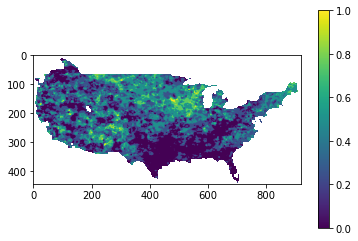

In [10]:
plt.imshow(np.flipud(volatility_dir[:,:,1]))
plt.colorbar()

<ipython-input-24-83894bea2962>:14: RuntimeWarning: Mean of empty slice
  data = np.nanmean(volatility_dir, axis=2)


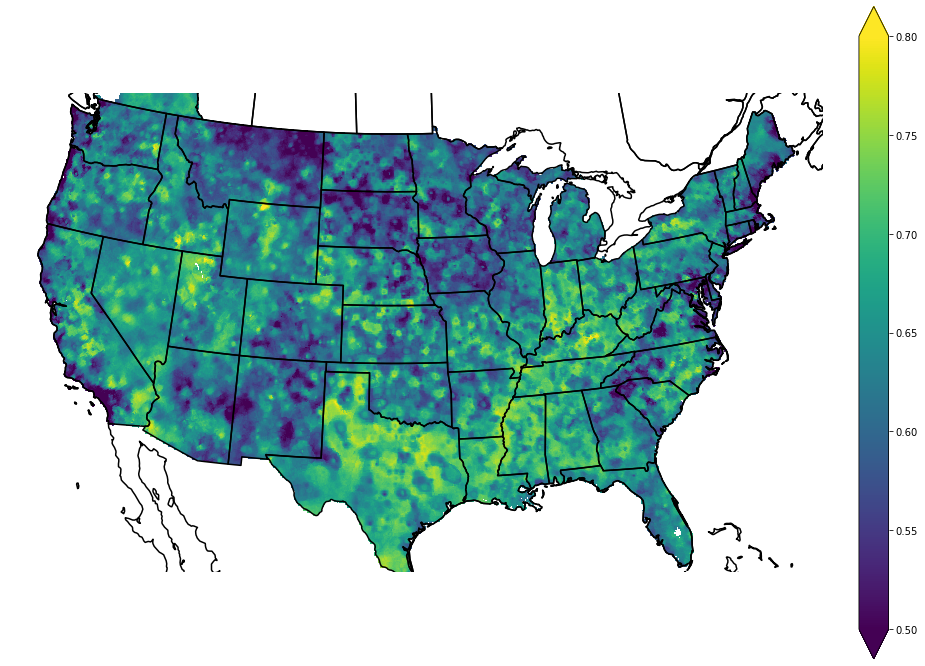

In [24]:
figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))

ax.axis('off')
ax.add_feature(cfeature.COASTLINE, linestyle='-', edgecolor= 'black', linewidth=1.5)
ax.add_feature(cfeature.STATES, linestyle='-', edgecolor= 'black', linewidth=1.5)
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())

gridlons= np.arange(-124.5937,-67.03,0.0625)
gridlats= np.arange(25.1562,52.8438,0.0625)

data = np.nanmean(volatility_dir, axis=2)
data = 1 - data

plot = plt.pcolormesh(gridlons, gridlats, data
                    , cmap= 'viridis', vmin= 0.5, vmax= 0.8, transform=crs.PlateCarree())

font = {'family':'serif','weight':'bold', 'size': 16}
cbar= plt.colorbar(plot,fraction=0.046, pad=0.04, extend= 'both')

plt.savefig('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/Figures/LIVNEH_Volatility_dir.jpeg',
          dpi=600)

plt.show()

In [26]:
np.save('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/LIVNEH_volatility95p.csv', volatility_95p)
np.save('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/LIVNEH_julianday.csv',julian_day)
np.save('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/LIVNEH_volatility_dir.csv',volatility_dir)
np.save('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/LIVNEH_trend_slope.csv',slope)
np.save('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/LIVNEH_trend_p-value.csv',p_value)